# Trying to set out the framework for the worm algorithm
### In several places I have put things have 0 added to multiplied by 1 or returning 0. Most of these are just place holders so the code can run.


In [1]:
import numpy as _np
import matplotlib.pyplot as _plt
import random
from time import process_time

# Set up H and $\beta$  and other fixed variables

In [2]:
# We set t = 1 for the all simulation parameters so that we can implement the dimensionless Hamiltonian

###################################################### Simulation parameter setting ##########################################################################
N = 2 # Number of total sites in one dimension
mu = 1.4 # Chemical constant
epsilon = 0.03
beta = 12 # beta is defined by 1/ (k * T) where T is the temperature, k is the Boltzmann constant
num_time_steps = int(beta / epsilon)

d = 3 # Number of spacial dimension. Not actually fully flexible, but comes up in formulas

###################################################### Hopping weight setting ##########################################################################
p_move_forward = min(1, _np.exp(mu * epsilon)) # The probability of moving forward in time given it is facing forward, either hop or staying
p_move_forward_hop = epsilon # The probability of hopping given the worm is moving forward (Assuming that we set t = 1 in the problem)
p_move_forward_straight = (1 - 2 * d * p_move_forward_hop) # Straight moving means no spatial hopping (only temporal hopping)
p_move_backward = min(1, _np.exp(-mu * epsilon)) # The probability of moving backwards giving the worm is facing backwards

print('p_move_forward: ' + str(p_move_forward))
print('p_move_forward_hop: ' + str(p_move_forward_hop))
print('p_move_forward_straight: ' + str(p_move_forward_straight))
print('p_move_backward: ' + str(p_move_backward))

weight_no_hop = _np.exp(mu * epsilon) * p_move_forward_straight
weight_hop = _np.exp(mu * epsilon) * p_move_forward_hop

print('weight_no_hop: ' + str(weight_no_hop))
print('weight_hop: ' + str(weight_hop))

class Grid_location(object):
    """
    an object for holding information about what is going on at each grid location
    """
    def __init__(self):
        self.is_particle = False # Whether or not there is a particle on that location.
        self.is_hardcore_boson_violated = False # Whether or not the hardcore boson constraint is violated
        
        """ Where_particle_came_from/is_going there are 2 numbers. The first is whether is moved in x(0)
        y(1) or z(2). The second (-1, 0, +1) is whether the previous/next position was 
        at the current coordinate, or +1 or -1 from it. 
        
        For example a trajector that goes (in Cartesian) (3,4,5) -> (3,5,5) -> (2,5,5) would have where_particle_came_from = [1, -1] and 
        where_particle_is_going = [0, -1] (It looks like we have to be careful with the sign!!)
        
        Note if the particle is stationary where_particle_came_from = [0, 0] or [1, 0] or [2, 0]. It doesn't matter
        """
        self.where_particle_came_from = [0, 0]
        self.where_particle_came_from_hardcore_boson_violated = [0, 0] # Specially used when hardcore boson constraint is violated
        self.where_particle_is_going = [0, 0]
        
        
    def set_where_particle_came_from(self, axis, direction): # axis can be x(0), y(1), z(2) and direction can be -1 and 1
        self.where_particle_came_from = [axis, direction]
    
    def set_where_particle_came_from_hardcore_boson_violated(self, axis, direction): # axis can be x(0), y(1), z(2) and direction can be -1 and 1
        self.where_particle_came_from_hardcore_boson_violated = [axis, direction]
    
    def set_where_particle_is_going(self, axis, direction): # axis can be x(0), y(1), z(2) and direction can be -1 and 1
        self.where_particle_is_going = [axis, direction]
    
    def place_particle(self):
        self.is_particle = True
        
    def remove_particle(self):
        self.is_particle = False
        
def observables(pathed_grid):
    """count up the number of particles and number of hops which gives all information needed to compute
    the weight and energy of the path, then returns the number of particles, the weight of the path and the energy"""
    num_particles = 0 # Running total of number of particles
    num_hops = 0 # Running total of number of steps in which those particles hop
    
    # Loop through the grid
    for x in _np.arange(N):
        for y in _np.arange(N):
            for z in _np.arange(N):
                # For each end location check if there is a path
                time = (num_time_steps - 1) # Start at the end time of the grid and work backwards
                loc = [x, y, z] # Location in space only
                
                if pathed_grid[loc[0], loc[1], loc[2], time].is_particle:
                    num_particles += 1
                
                    # Go through the path
                    while time > 0:
                        step = pathed_grid[loc[0], loc[1], loc[2], time] # The grid_location object where we are in path

                        if step.where_particle_came_from[1] != 0: # If this is 0, there is no hopping
                            num_hops += 1
                                                    
                        # Update location to the previous step on the path
                        loc[step.where_particle_came_from[0]] += step.where_particle_came_from[1]
                        loc[step.where_particle_came_from[0]] %= N #isn't Python great that %= works just like += but for mod 
                        time -= 1
    
    e_tilda = (2 * d * num_particles) - (num_hops / beta)
    weight = (weight_hop ** num_hops) * (weight_no_hop ** ((num_time_steps - 1) * num_particles - num_hops))
    return [num_particles, e_tilda, weight]

"""
grid has indices for time steps, x, y and z. Then at each grid location there is a grid_location object that says whether
there is a particle, where it came from and where it is going.
I think it is good to say where a particle came from each step because the worm algorithm only every  follows a path
backwards.
"""
grid = _np.full((N,N,N, num_time_steps), Grid_location() )

p_move_forward: 1
p_move_forward_hop: 0.03
p_move_forward_straight: 0.8200000000000001
p_move_backward: 0.9588697805724845
weight_no_hop: 0.8551734725756259
weight_hop: 0.03128683436252289


# Grid visualization

In [3]:
def plot_grid(pathed_grid, t):
    """This is supposed to plot a 3d grid showing one time step. It should have a green dot at each point where there
    is a particle. There should also be a blue line from each particle to where it came from in the previous time step,
    and a red line leading to where it is going on the next time step. Ideally this would eventually lead to an
    animated version where it shows each time step for ~1s.
    This is currently not working (at least in the edge case where there are not particles, or particles at every point.)
    """
    background_points = []
    particle_points = []
    particle_going_tos = []
    particle_coming_froms = []
    for x in range(N):
        for y in range(N):
            for z in range(N):
                current_location = pathed_grid[x, y, z, t]
                if not current_location.is_particle:
                    background_points.append([x,y,z])
                else:
                    loc = [x,y,z]
                    next_loc = loc.copy()
                    next_loc[current_location.where_particle_is_going[0]] += current_location.where_particle_is_going[1]
                    next_loc[current_location.where_particle_is_going[0]] %= N
                    previous_loc = loc.copy()
                    previous_loc[current_location.where_particle_came_from[0]] += current_location.where_particle_came_from[1]
                    previous_loc[current_location.where_particle_came_from[0]] %= N
                    particle_points.append(loc)
                    particle_going_tos.append(next_loc)
                    particle_coming_froms.append(previous_loc)
                    
                
    ax = _plt.axes(projection='3d')
    
    bp =_np.array(background_points).T
    print(background_points, bp)
    print(particle_points)
    
    ax.scatter(bp[0], bp[1], bp[2], color="grey", marker=".", alpha="0.5")
    ax.scatter(*_np.array(particle_points).T)
    for i in range(length(particle_points)):
        ax.plot(*_np.array([particle_going_tos[i], particle_points[i]]).T, color="red")
        ax.plot(*_np.array([particle_coming_froms[i], particle_points[i]]).T, color="blue")

In [4]:
#plot_grid(grid, 0)

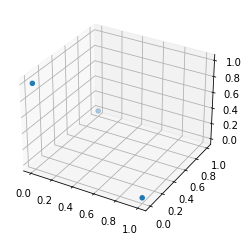

In [5]:
ax = _plt.axes(projection='3d')
ax.scatter3D(*_np.array([[0,0,1], [0,1,0], [1,0,0]]))

## This part is the actual worm algorithm

In [6]:
def unit_move_forward(loc, hop_axis, hop_direction, N, num_time_steps): # Temporal forward
    new_loc = loc.copy()
    new_loc[hop_axis] = (loc[hop_axis] + hop_direction) % N # Periodic condition
    new_loc[3] = (loc[3] + 1) % num_time_steps
    
    return new_loc

def unit_move_backward(loc, hop_axis, hop_direction, N, num_time_steps): # Temporal backward
    new_loc = loc.copy()
    new_loc[hop_axis] = (loc[hop_axis] + hop_direction) % N # Periodic condition
    new_loc[3] = (loc[3] - 1) % num_time_steps
    
    return new_loc
    
def move_forward(loc, pathed_grid):
    """
    This function updates the grid if the worm moves forward. It needs to do 3 things:
    1) choose a next location to go to
    2) update where_particle_is_going on the old location and where_particle_came_from on the new location
    3) deal with complications if there is already a particle at the location"""
    
    facing_forward = True # Defines the final temporal direction after finishing the function
    
    #### Store the old & new location information first ####
    old_grid_location = pathed_grid[tuple(loc)]  
    new_loc = loc.copy() # Initialization
      
    #### Hopping ####
    if random.uniform(0, 1) < p_move_forward_straight:
        # Don't hop spatially, just move forward in time
        hop_axis = 0
        hop_direction = 0
        new_loc = unit_move_forward(loc, hop_axis, hop_direction, N, num_time_steps)
        
    else:        
        # Hop both temporal and spatial at this time step
        hop_axis = random.randint(0, d - 1) # Get an integer 0 ~ 2 inclusive for the axis to move on (0: x, 1: y, 2: z)
        hop_direction = 2 * random.getrandbits(1) - 1 # For the direction, get +1 = 2 * 1 - 1 or -1 = 2 * 0 - 1
        
        new_loc = unit_move_forward(loc, hop_axis, hop_direction, N, num_time_steps)
        
        # Update the old location to say where it is going
        old_grid_location.set_where_particle_is_going(hop_axis, hop_direction)    
    
    #### Check the hardcore boson constraint ####
    new_grid_location = pathed_grid[tuple(new_loc)]
    
    if new_grid_location.is_particle:
        # Now in the condition of at a spot with two particles and the arrow facing (hardcore boson constraint is violated)
        facing_forward = False # Now we have to move backward 
        new_grid_location.is_hardcore_boson_violated = True
        
        # Save the information of original path
        original_axis = new_grid_location.where_particle_came_from[0]
        original_direction = new_grid_location.where_particle_came_from[1]
        
        new_grid_location.set_where_particle_came_from_hardcore_boson_violated(original_axis, original_direction)
        new_grid_location.set_where_particle_came_from(hop_axis, -hop_direction)
        
    else: 
        # If there is no particle at the new location, just update it
        new_grid_location.set_where_particle_came_from(hop_axis, -hop_direction)
        new_grid_location.place_particle()
        
    return new_loc, facing_forward
        
            
def update_grid(pathed_grid):
    """
    worm update algorithm goes here
    """
    # Pick initial site
    x0, y0, z0 = random.randrange(N), random.randrange(N), random.randrange(N)
    t0 = random.randrange(num_time_steps)
    loc0 = [x0, y0, z0, t0] # Original location
    
    # Initial up arrow if there is no particle
    facing_forward = not(pathed_grid[tuple(loc0)].is_particle)
    
    # Current location of the worm
    tail = loc0.copy()
    head = loc0.copy() # When copying the array, be careful with shallow & deep copy !!
    keep_going = True
    
    counter = 0
    while keep_going:        
        #print("hi", loc, facing_forward)
        if facing_forward:
            if random.uniform(0, 1) <= p_move_forward: # Move forward proposal accepted
                head, facing_forward = move_forward(head, pathed_grid)
            else:
                facing_forward = False
                
        else:
        #     For the case of the worm facing backwards     
        #     For facing backwards the steps are as follows
        #     1) go back one along the path, deleting the particle at the current location
        #     2) switch the arrow to something like facing forward, except the probabilities of adding a new step
        #       are different
            
            current_grid_location = pathed_grid[tuple(head)]
            
            # Hopping axis and direction setting (be careful with the hardcore boson violation condition)       
            if current_grid_location.is_hardcore_boson_violated == True:
                hop_back_axis = current_grid_location.where_particle_came_from_hardcore_boson_violated[0]
                hop_back_direction = current_grid_location.where_particle_came_from_hardcore_boson_violated[1]  

            else:
                hop_back_axis = current_grid_location.where_particle_came_from[0]
                hop_back_direction = current_grid_location.where_particle_came_from[1]     
            
            # Particle removal (be careful with the hardcore boson violation condition)
            if counter!=0 and current_grid_location.is_hardcore_boson_violated == False: current_grid_location.remove_particle() # If it is the initial backward try, we should not remove the particle
            
            # Edge removal (be careful with the hardcore boson violation condition)
            if current_grid_location.is_hardcore_boson_violated == True:
                current_grid_location.set_where_particle_came_from_hardcore_boson_violated(0, 0) # Remove the spatial hopping edge
            else:
                current_grid_location.set_where_particle_came_from(0, 0) 
            
            current_grid_location.is_hardcore_boson_violated = False          
            
            if random.uniform(0, 1) <= p_move_backward: # Move back proposal accepted
                head = unit_move_backward(head, hop_back_axis, hop_back_direction, N, num_time_steps)
                new_grid_location = pathed_grid[tuple(head)]
                new_grid_location.set_where_particle_is_going(0, 0) # Remove the spatial hopping edge
                
            else:
                head = unit_move_backward(head, hop_back_axis, hop_back_direction, N, num_time_steps)
                new_grid_location = pathed_grid[tuple(head)]
                new_grid_location.set_where_particle_is_going(0, 0) # Remove the spatial hopping edge
                
                head, facing_forward = move_forward(head, pathed_grid)
                
        # Now check whether we have arrive back at the place we started
        # I don't think it is possible to arrive back at the start without having finished the worm - I also agree (Jiyong)
        keep_going = (head != tail)
        counter += 1

    # Finally removing the particle at the tail
    pathed_grid[tuple(tail)].remove_particle()
    
    return pathed_grid

# This next box is where the simulation acutally happens

1.94 seconds so far, estimated time remaining is  191.81
-----------------1.0 New grid created----------------------
3.88 seconds so far, estimated time remaining is  189.88
-----------------2.0 New grid created----------------------
5.55 seconds so far, estimated time remaining is  179.35
-----------------3.0 New grid created----------------------
9.5 seconds so far, estimated time remaining is  228.0
-----------------4.0 New grid created----------------------
15.22 seconds so far, estimated time remaining is  289.16
-----------------5.0 New grid created----------------------
20.97 seconds so far, estimated time remaining is  328.51
-----------------6.0 New grid created----------------------
26.83 seconds so far, estimated time remaining is  356.43
-----------------7.0 New grid created----------------------
32.72 seconds so far, estimated time remaining is  376.27
-----------------8.0 New grid created----------------------
39.05 seconds so far, estimated time remaining is  394.81
----

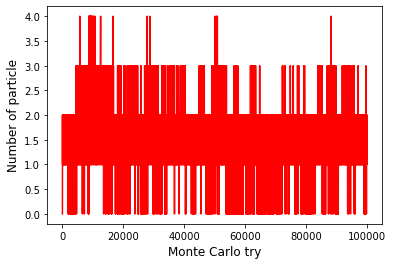

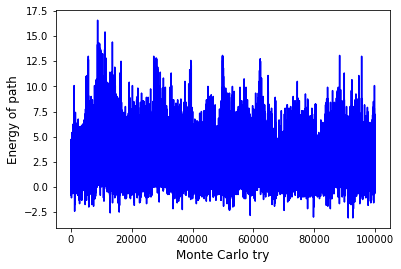

In [7]:
################# Make the block ###################
def block(array, N):
    # Device the given array into blocks with length N
    
    l = int(len(array) / N)
    
    blocked_array = _np.zeros([l, N])
    
    for i in range(0, l):
        block_start = i * N
        block_end = block_start + N
        
        blocked_array[i] = array[block_start: block_end]
        
    return blocked_array

################# Calculate the whole average of blocks ###################
def total_block_average(blocked_array_observable):
    # Device the given array into blocks with length N
    
    l = len(blocked_array_observable)
    each_block_average_array = _np.zeros(l)
    
    for i in range(l):
        each_block_average = _np.average(blocked_array_observable[i])
        each_block_average_array[i] = each_block_average

    return _np.average(each_block_average_array)


# 4-dimensional array so that we can store the information of both space and time
grid = _np.full((N, N, N, num_time_steps), Grid_location()) # Initialization

# If we use the above definition, all objects refer to the same memory address.
# In this case, if we change one grid location, all grid locations are changed simultaneously
# Therefore, we have to initialize the grid as below
for x in range(N):
    for y in range(N):
        for z in range(N):
            for t in range(num_time_steps):
                grid[x, y, z, t] = Grid_location()

num_trials = 100000 # I think in one of the lectures, prof said we should expect this ot take ~1 million trials
ns = [] # Number of particles in each trial
cumavg_ns = []
es = [] # Energy of path in each trial
cumavg_es = []
Ws = [] # Weight of paths in each trial
cumavg_Ws = []

Frequency_Estimated = 1000
t1 = process_time()
w_cumavg = 0
n_cumavg = 0
e_cumavg = 0
for counter in range(num_trials):
    num_particles, e_tilda, weight = observables(grid)
    Ws.append(weight)
    w_cumavg = w_cumavg*counter/(counter+1)+weight/(counter+1)
    cumavg_Ws.append(w_cumavg)
    ns.append(num_particles)
    n_cumavg = n_cumavg*counter/(counter+1)+num_particles/(counter+1)
    cumavg_ns.append(n_cumavg)
    es.append(e_tilda)
    e_cumavg = e_cumavg*counter/(counter+1)+e_tilda/(counter+1)
    cumavg_es.append(e_cumavg)
    grid = update_grid(grid)
    if counter%Frequency_Estimated == 0 and counter!=0:
        t2 = process_time()
        print("{} seconds so far, estimated time remaining is ".format(round(t2-t1,2)), round(-(t2-t1)+(t2-t1)*num_trials/(counter),2))
    
        print('-----------------' + str(counter/Frequency_Estimated) + ' New grid created----------------------')
    
Monte_Carlo_try = range(num_trials)
_plt.rcParams['figure.facecolor'] = 'white'
_plt.plot(Monte_Carlo_try, ns, 'r')
_plt.xlabel('Monte Carlo try', fontsize = 12)
_plt.ylabel('Number of particle', fontsize = 12)

_plt.figure()
_plt.plot(Monte_Carlo_try, es, 'b')
_plt.xlabel('Monte Carlo try', fontsize = 12)
_plt.ylabel('Energy of path', fontsize = 12)

block_size = 2500
block_size = 0
#why are these here? 
ns = ns[block_size:]
es = es[block_size:]
block_size = 2500
ns_block = block(ns, block_size)
es_block = block(es, block_size)

print(total_block_average(ns_block))
print(total_block_average(es_block))


(-1.0, 18.0)

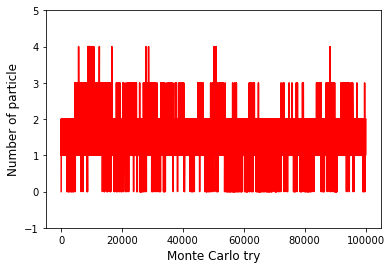

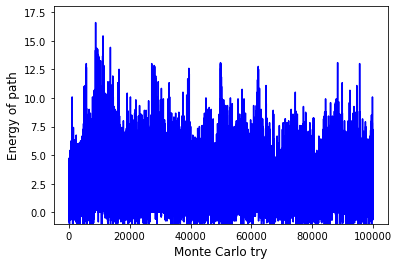

In [8]:
Monte_Carlo_try = range(num_trials)
emax = max(es)
nmax = max(ns)
_plt.rcParams['figure.facecolor'] = 'white'
_plt.plot(Monte_Carlo_try, ns, 'r')
_plt.xlabel('Monte Carlo try', fontsize = 12)
_plt.ylabel('Number of particle', fontsize = 12)
_plt.ylim([-1, _np.ceil(nmax*1.1)])

_plt.figure()
_plt.plot(Monte_Carlo_try, es, 'b')
_plt.xlabel('Monte Carlo try', fontsize = 12)
_plt.ylabel('Energy of path', fontsize = 12)
_plt.ylim([-1, _np.ceil(emax*1.04)])



# Now do analysis, plot results, etc

In [9]:
#cumavg_ns = []
#for i in range(1,len(ns)+1):
#    cumavg_ns.append(_np.mean(ns[:i]))
#    
#cumavg_es = []
#for i in range(1,len(es)+1):
#    cumavg_es.append(_np.mean(es[:i]))

n_end = cumavg_ns[-1]
e_end = cumavg_es[-1]

100000

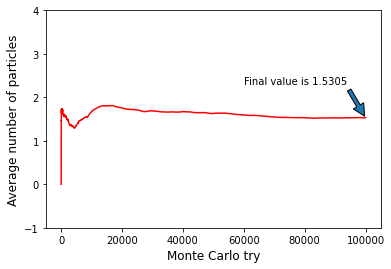

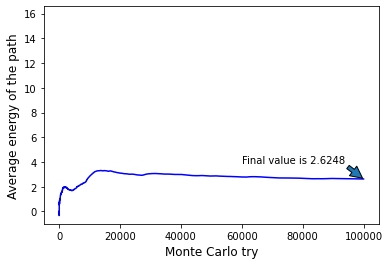

In [11]:
Monte_Carlo_try = range(num_trials)
_plt.plot(Monte_Carlo_try, cumavg_ns, 'r')
_plt.xlabel('Monte Carlo try', fontsize = 12)
_plt.ylabel('Average number of particles', fontsize = 12)
_plt.ylim([-1, nmax])
_plt.annotate('Final value is '+str(round(n_end,4)), xy =(num_trials, round(n_end,4)),
                xytext =(0.6*num_trials, 1.5*round(n_end,4)), 
                arrowprops = dict(
                                  shrink = 0.05),)
_plt.figure()
_plt.plot(Monte_Carlo_try, cumavg_es, 'b')
_plt.xlabel('Monte Carlo try', fontsize = 12)
_plt.ylabel('Average energy of the path', fontsize = 12)
_plt.ylim([-1, emax])
_plt.annotate('Final value is '+str(round(e_end,4)), xy =(num_trials, round(e_end,4)),
                xytext =(0.6*num_trials, 1.5*round(e_end,4)), 
                arrowprops = dict(
                                  shrink = 0.05),)
test1 = _np.array([1,2,3])
test2 = _np.array([2,3,4])
test1==test2
_np.all(test1==test2)

len(ns)

## Scratch Work

In [ ]:
grid = _np.full((2,2), Grid_location())
grid

In [ ]:
facing_forward = True

if facing_forward:
    if random.uniform(0, 1) <= 0.5:
        print(3)
    else:
        facing_forward = False
        print(0)
            
else:
    print(1)

In [ ]:
_np.shape(ns)